In [1]:
from __future__ import division

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
import colorcet as cc
sns.set(style="white", palette="deep", color_codes=True)
sns.set_context("notebook", font_scale=1.2)
plt.rcParams["axes.labelsize"] = 16

def force_aspect(ax, aspect=1):
    """force a matplotlib axis to have the specified aspect ratio on the screen"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    a = (np.max(xlim) - np.min(xlim)) / (np.max(ylim) - np.min(ylim))
    ax.set_aspect(a / aspect)
    
golden_ratio = 1.61803398875

# First Attempt at a Bayesian Calculation

In the previous example, we wrote a linear function which was able to guess the authorship of a paper based on word usage... but how much confidence can we put into this determination?  This is a perfect time to use Bayes' Theorem!

In this calculation I will assume that each author uses words randomly, following a Poisson distribution with some constant (but unknown) rate.  As a first guess, I'll assume this rate is exactly equal to the mean rate in the training set... an assumption which we will revisit later at the end of this notebook.

I'll denote the true mean rates at which Madison and Hamilton use the word $w_i$ as $\mu_{\text{M},i}$ and $\mu_{\text{H},i}$, respectively.  For now I'll assume that these true are equal to the measured rates $\hat{\mu}_{\text{M},i}$ and $\hat{\mu}_{\text{H},i}$ in some training set.  *If* Madison uses this word following a Poisson distribution with an average rate $\mu_{\text{M},i}$, then the probability that he might use this word $x_i$ times in a document of length $n$ words is:
\begin{equation}
P(x_i\,|\,\text{M}) = \frac{(n \mu_{\text{M},i})^{x_i} \; \exp(-n \mu_{\text{M},i})}{x_i !}
\end{equation}

Now let's assume we have some document of length $n$ words in which the word $w_i$ occurs $x_i$ times.  I can use Bayes' theorem to re-express the above equation as the "inverse probability" that Madison wrote the doucument:
\begin{equation}
P(\text{M}\,|\,x_i) = \frac{P(x_i\,|\,\text{M}) \, P(\text{M})}{P(x_i)},
\end{equation}

where $P(\text{M})$ describes any prior information we have about the probability that Madison wrote the document, and $P(x_i)$ is a normalizing factor which can be neglected when we're only comparing the relative likelihood of two different authors.

Using the above, the difference in log-likelihoods that this word $w_i$ could have occurred $x_i$ times in $n$ words of text by Madison and Hamilton is:
\begin{equation}
\lambda_i \equiv \ln P(x_i\,|\,\text{M}) - \ln P(x_i\,|\,\text{H}) = x_i \ln(\mu_{\text{M},i}/\mu_{\text{H},i}) - n (\mu_{\text{M},i} - \mu_{\text{H},i})
\end{equation}

We want the relative likelihood that Madison or Hamilton wrote some document, which we can express as
\begin{equation}
\log\left(\frac{P(\text{M}\,|\,\vec{x})}{P(\text{H}\,|\,\vec{x})}\right) = \sum_i \lambda_i
\end{equation}

Let's try it!

## First, we need to count word frequencies and measure Madison's and Hamilton's usage for some training set:

We'll use the same set of stop words as before, and count them up in exactly the same way:

In [2]:
stopwords = ["a", "about", "above", "according", "across", "affect", "after", \
"again", "against", "all", "almost", "alone", "along", "already", \
"also", "although", "always", "among", "an", "and", "another", "any", \
"anyone", "anything", "anywhere", "apt", "are", "argue", "around", \
"as", "asserted", "at", "back", "be", "became", "because", "become", \
"becomes", "been", "before", "behind", "being", "better", "between", \
"both", "but", "by", "can", "cannot", "common", "commonly", \
"comparable", "consequently", "considerable", "could", "course", \
"degree", "did", "do", "done", "down", "dramatically", "during", \
"each", "either", "enough", "even", "ever", "every", "everyone", \
"everything", "everywhere", "extent", "few", "find", "first", \
"follow", "for", "four", "from", "full", "further", "get", "give", \
"go", "had", "has", "have", "he", "hence", "her", "here", "herself", \
"him", "himself", "his", "how", "however", "if", "imply", \
"importance", "in", "interest", "into", "is", "it", "its", "itself", \
"join", "keep", "kind", "largely", "last", "least", "less", "made", \
"many", "may", "me", "might", "more", "moreover", "most", "mostly", \
"much", "must", "my", "myself", "necessary", "never", "next", "no", \
"nobody", "noone", "nor", "not", "nothing", "now", "nowhere", "of", \
"off", "often", "on", "once", "one", "only", "or", "other", "others", \
"our", "out", "over", "part", "particularly", "per", "perhaps", \
"possible", "principle", "put", "rather", "requisite", "same", \
"second", "see", "seem", "seemed", "seeming", "seems", "several", \
"shall", "she", "should", "show", "side", "since", "so", "some", \
"someone", "something", "somewhere", "still", "substance", "such", \
"suggest", "take", "than", "that", "the", "their", "them", "then", \
"there", "therefore", "these", "they", "thing", "this", "those", \
"though", "three", "through", "throughout", "thus", "to", "together", \
"too", "toward", "two", "typical", "typically", "under", \
"unexpected", "until", "up", "upon", "us", "use", "using", "very", \
"was", "we", "well", "were", "what", "when", "where", "whether", \
"which", "while", "whilst", "who", "whole", "whose", "why", "will", \
"with", "within", "without", "would", "yet", "you", "your", "yours"]

In [3]:
import nltk
from collections import Counter

In [4]:
def measure(filename):
    """tally up the occurrences of each stop word in document filename"""
    with open(filename, 'r') as f:
        raw = f.read()

    all_words = nltk.word_tokenize(raw.lower())
    num = len(all_words)

    c = Counter(all_words)
    x = [ c[w] for w in stopwords ]
    
    return (num, np.asarray(x))

In [5]:
# read in the training data for hamilton and madison
nm, xm = measure('../authors/madison-corpus-small.txt')
nh, xh = measure('../authors/hamilton-corpus-small.txt')

# estimate mean count rate
mu_m = xm/nm
mu_h = xh/nh

## Next, we can use Bayes' theorem and Poissonian statistics to infer the author of a particular file which isn't in the training set:

In [6]:
def guess_author(filename):
    nu, xu = measure(filename)

    # assume Poissonian statistics, with mean rates given by the training data
    #
    # floor the rates at one occurrence per million words.  (anybody can say 
    # anything once per million words, right?)
    #
    lnprob = xu * np.log((mu_m+1e-6)/(mu_h+1e-6)) - nu * (mu_m - mu_h)
    return int(round(np.sum(lnprob)))

In [7]:
import glob

First, let's just make sure that this reproduces the training data; i.e., that our model agrees that Madison wrote everything we said he did.  These numbers should all be positive:

In [8]:
print "Should all be positive:"
print map(guess_author, glob.glob('../authors/madison/*.txt'))

Should all be positive:
[64, 68, 70, 82, 82, 63, 45, 54, 67, 40, 89, 88, 74, 73, 106]


And we'll repeat the exercise for Hamilton's (much larger) training set.  These numbers should all be negative:

In [9]:
print "Should all be negative:"
print map(guess_author, glob.glob('../authors/hamilton/*.txt'))

Should all be negative:
[-57, -120, -41, -96, -179, -38, -76, -57, -127, -39, -36, -46, -101, -97, -79, -41, -43, -91, -83, -77, -45, -77, -92, -34, -75, -72, -21, -31, -93, -108, -105, -122, -121, -56, -38, -86, -92, -107, -65, -20, -41, -102, -19, -173, -43, -78, -99, -104, -56, -37, -127]


Finally, we run it on the disputed papers: positive numbers mean that Madison wrote them, negative numbers mean that Hamilton wrote them:

In [10]:
print map(guess_author, glob.glob('../authors/unknown-federalist/*.txt'))

[47, 31, 10, 22, 33, 70, 42, 45, 38, 14, 46, 44, 34, 49]


Great, that was super-easy!  Moreover, we've found that Madison wrote all of the disputed papers, which certainly confirms my prejudice!

...but solving a 200-year old historical mystery probably shouldn't be this easy!  And indeed there are two problems with this analysis, both potentially serious:
1. Madison and Hamilton are under no oblication to follow the Poissonian distribution, regardless of anything I say, and
2. We've assumed that the unknown mean rates at which they use words $\mu_{\text{M},i}$ and $\mu_{\text{H},i}$ are exactly equal to the measured rates $\hat{\mu}_{\text{M},i}$ and $\hat{\mu}_{\text{H},i}$.  Since our analysis selects out words with large fractional differences in $\mu$, this creates a selection bias and we're sensitive to noise in the rare words in the training set.

both problems lead us to overstate the certainty in our determinations, perhaps by many orders of magnitude.  Indeed, the certainties we're seeing should be alarming: can the probability that Hamilton wrote a certain paper based on his word usage *really* be $1-e^{-127}$, just on the basis of a few occurrences of the word *upon*?  And even though we see absurdly high probabilities for the disputed papers, they're significantly lower than we have for the training data... this is a clear sign of selection (or "regression") effects in our model.

# Checking our assumption of the Poisson distribution:

The first possible problem is easy to check, but difficult to fix.  Hence, we'll check it first and fix it last.  We can quickly check the Poisson-ness of the data by glancing at some plots:

In [11]:
def sample_usage(filename):
    """split filename into chunks of 1000 words, then tally the instances of
    each of the stopwords in each chunk"""
    with open(filename, 'r') as f:
        raw = f.read()

    all_words = nltk.word_tokenize(raw.lower())

    n=1000
    samples = [ all_words[i:i + n] for i in xrange(0, len(all_words), n) ]

    c = [ Counter(s) for s in samples ]
    x = [ [cc[w] for w in stopwords] for cc in c ]

    # transpose and return
    return map(list, zip(*x))

In [12]:
data = sample_usage('../authors/madison-corpus-small.txt')

In [13]:
from scipy.stats import poisson

In [25]:
def fix_axes(ax, both=False):
    xmin, xmax = ax.get_xlim()
    xmin = np.max([0.0, xmin])
    ax.set_xlim([xmin, xmax])

    if both:
        ax.set_ylim([0.0, 1.0])
    
def check_poisson_fit(word):
    fig=plt.figure(figsize=(12, 4))
    gs=GridSpec(1,2) # one row, two columns

    ax1=fig.add_subplot(gs[0,0]) # first row, first column
    ax2=fig.add_subplot(gs[0,1]) # second row, second column

    # first, plot the probability distribution function.
    # (this is a more direct comparison, but also noisy)
    #
    # start by plotting a histogram of the word's usage
    counts = data[stopwords.index(word)]
    sns.distplot(counts, kde=False, ax=ax1, norm_hist=True)

    # overly the assumed Poisson distribution
    x = np.arange(np.min(counts)-1, np.max(counts)+2)
    y = poisson.pmf(x, np.mean(counts))
    ax1.plot(x, y)
    ax1.set_title('probability distribution')
    
    
    # next, plot the cumulative distribution function, which is less noisy
    #
    # start with the empirical CDF, or EDF
    x = np.sort(counts)
    y = np.arange(1,len(counts)+1).astype(float)/len(counts)

    # if the EDF is a stair-step plot, it's only defined at the top-left corner
    # of each step (right-disontinuous)
    ind = np.where(np.diff(x) != 0)[0]

    # make a "stair-step" plot by repeating each index
    x1 = np.repeat(x[ind], 2)[1:]
    y1 = np.repeat(y[ind], 2)[:-1]

    ax2.plot(x1, y1)
    ax2.plot(x[ind], y[ind], 'o', color='c')
    
    # overlot the assumed Poisson distribution
    x = np.arange(np.min(counts)-1, np.max(counts)+2)
    y = poisson.cdf(x, np.mean(counts))
    ax2.plot(x, y)
    ax2.set_title('cumulative probability')

    fix_axes(ax1)
    fix_axes(ax2, both=True)
    
    force_aspect(ax1, golden_ratio)
    force_aspect(ax2, golden_ratio)
    
    plt.suptitle(word)

Our assumption seems ok for some words, such as *with*, *of*, and *this*:

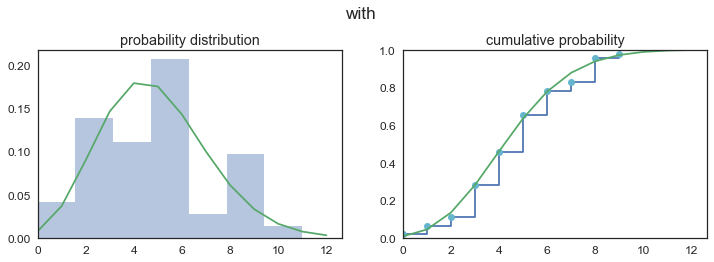

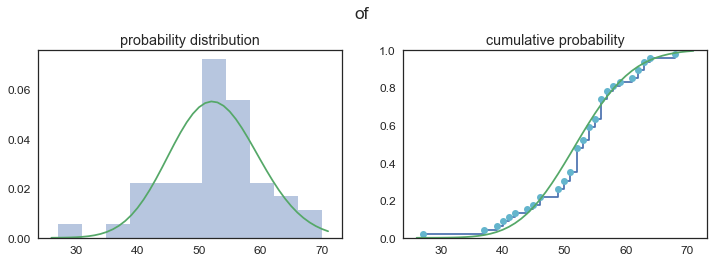

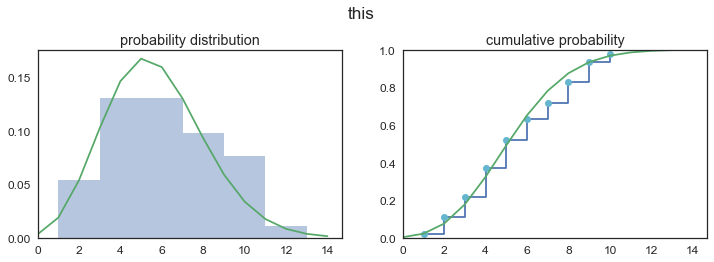

In [26]:
check_poisson_fit('with')
check_poisson_fit('of')
check_poisson_fit('this')

For other words, such as *the* and *his*, the assumption is not so good:

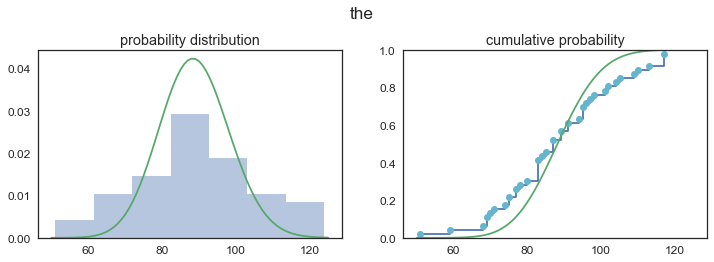

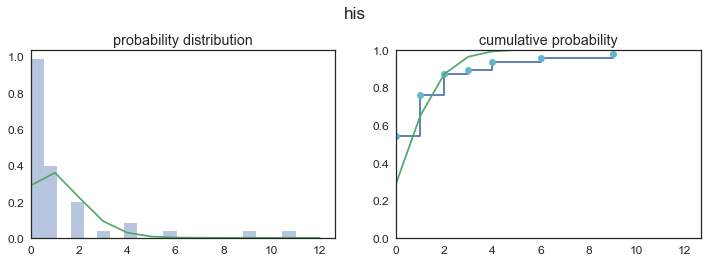

In [27]:
check_poisson_fit('the')
check_poisson_fit('his')

The word *his* is especially terrible: Madison uses it on average 1.2 times per thousand words, but he once used it 11 times!  According the the Poisson distribution, there is only a one-in-ten-million chance that this could happen, even though our model was *trained* on this same data!  Such a marked inconsistency clearly indicates a fault in the model

In [17]:
counts = data[stopwords.index('his')]
poisson.pmf(np.max(counts), np.mean(counts))

7.6733328228283944e-08

Such tiny numbers are scary because they hugely influence the quoted certainty in our calculations.  Imagine the string of text in which Madison used the word *his* 11 times: based on that word alone, our model gives a probability of less than one in ten million that Madison wrote it.

Now imagine that *every other word* points in Madison's direction, and against Hamilton's, with a total likelihood of a million to one.  That would seem like pretty darn good evidence that Madison wrote it, but our model would give 10:1 odds that Hamilton wrote it... just because of the word "his."  And this is for something in the training set!

But since it's easier to deal with the other problem, we'll take a look at that one first:

# Handling uncertainty in the Poisson parameters

Another key problem with our anaylsis is that we simply assumed that the "true" mean rates $\mu$ are simply given by the estimated rates $\hat{\mu}$ measured in the training data.  But our training set is small, many of the words are rare, and so our esimates of the true rates probably aren't very good.

Our likelihood model is sensitive to $\Delta \equiv \mu_{\text{M}} - \mu_{\text{H}}$.  But this is a randomly fluctuating quantity, and our fractional uncertainty in it can be huge for rare words.  This means that we strongly emphasize rare words which happened to have $\Delta$ fluctuate upwards in magnitude in our training set, and that we strongly de-emphasize words which happened to have $\Delta$ fluctuate towards zero.  It's not a good thing to be so sensitive to noise!

A related problem is the question of what to do with words which don't appear in the training set.  The measured rate $\hat{\mu} = 0$, which we then floor to $\hat{\mu} = 10^{-6}$.  If this word then occurs in a document, we attach a probability of $10^{-6}$ to it.  (And if it occurs *twice*, we give it a probability of $10^{-12}$!)  Effectively, we're saying that authors are *never* allowed to use words which don't occur in the training set.  But this is a terrible assumption, especially when we're analyzing rare words with small training sets.  So we need to do better.

In this section, I'll follow the (amazingly clever) analysis by Mosteller & Wallace (1964), which is one of the first non-classified Bayesian analyses of a real-world problem.  It's a classic paper, beautifully written, and well worth reading!

We'll start by defining two new parameters: $\sigma = \mu_{\text{M}} + \mu_{\text{H}}$, which measures the mean rate of usage for a word, and $\tau = \mu_{\text{M}} / \sigma$, which measures the word's ability to distinguish Madison from Hamilton.  I'll keep my arbitrary convention of flooring the rates at one per million:

In [19]:
sigma = mu_m + mu_h
tau = mu_m / (sigma + 1.0e-6)

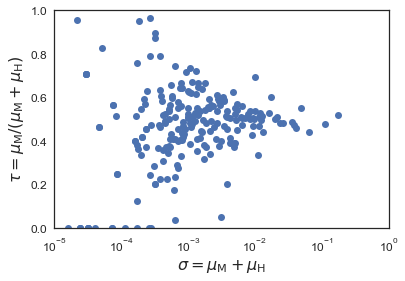

In [29]:
plt.semilogx(sigma, tau, 'o')
ax = plt.gca()
ax.set_xlim([1e-5, 1e0]);
ax.set_ylim([0, 1]);
ax.set_xlabel(r'$\sigma = \mu_{\mathrm{M}} + \mu_{\mathrm{H}}$')
ax.set_ylabel(r'$\tau = \mu_{\mathrm{M}} / (\mu_{\mathrm{M}} + \mu_{\mathrm{H}})$');

Mosteller and Wallace propose to move forward by assuming that $\sigma$ and $\tau$ represent something fundamental about the way Madison and Hamilton choose their words, and that *they* follow some known disbribution, say, the $\beta$ distribution:
\begin{equation}
P(\sigma,\,\tau) = \frac{\tau^{\gamma-1} \; (1-\tau)^{\gamma-1}}{B(\gamma,\gamma)},
\end{equation}

with $\gamma = \beta_1 + \beta_2 \sigma$.

Nevermind *why* this might be the case... I don't agree with it either.  For now, let's use it and try to reproduce Mosteller and Wallace, and then we'll see why this is brilliant.

What we want to do is use this to estimate the difference between the "true" mean rates $\mu$ (which we don't know) and the observed rates $\hat{\mu}$ (which may be subject to significant selection bias).  We'll do this by assuming that $\sigma$ and $\tau$ naturally follow the $\beta$ distribution.  The prior probability for the parameters $\sigma$ and $\tau$ is therefore:
\begin{equation}
\log P(\sigma, \tau) = (\beta_1 + \beta_2 \sigma - 1) \times \log[\tau (1-\tau)] + \text{const.}
\end{equation}

Using the Poisson distribution now with known parameters $\sigma$ and $\tau$, we have the conditional probability to see some word occur $x_{\text{H}}$ in $n_{\text{H}}$ words of Hamilton's text and $x_{\text{M}}$ in $n_{\text{M}}$ words of Madison's text:
\begin{align}
\log P(x_{\text{H}},x_{\text{M}}\,|\,\sigma,\tau) &= 
\log\left[\frac{(n_{\text{M}} \mu_{\text{M}})^{x_{\text{M}}} \; \exp(- n_{\text{M}} \mu_{\text{M}})}{x_{\text{M}}!}\right]
+ \log\left[\frac{(n_{\text{H}} \mu_{\text{H}})^{x_{\text{H}}} \; \exp(- n_{\text{H}} \mu_{\text{H}})}{x_{\text{H}}!}\right] \\
&= - n_{\text{M}} \sigma \tau + x_{\text{M}} \log\left[n_{\text{M}} \sigma \tau \right] - \log(x_{\text{M}}!) \\
&\phantom{=} - n_{\text{H}} \sigma (1-\tau) + x_{\text{H}} \log\left[n_{\text{H}} \sigma (1-\tau) \right] - \log(x_{\text{H}}!)
\end{align}

Next, we use Bayes' theorem to estimate the true values of $\sigma$ and $\tau$, based on the observed frequencies $x$:
\begin{equation}
\log P(\sigma, \tau \,|\, x_{\text{M}}, x_{\text{H}}) = \log P(x_{\text{H}},x_{\text{M}}\,|\,\sigma,\tau) + \log P(\sigma, \tau) + \text{const.}
\end{equation}

after some algebra, this reduces to something we can type into the computer:
\begin{align}
\log P(\sigma, \tau \,|\, x_{\text{M}}, x_{\text{H}}) 
&= (x_{\text{M}} + x_{\text{H}}) \log\sigma \\
&\phantom{=} + (x_{\text{M}} + \beta_1 + \beta_2 \sigma - 1) \log \tau \\
&\phantom{=} + (x_{\text{H}} + \beta_1 + \beta_2 \sigma - 1) \log(1-\tau)\\
&\phantom{=} + (n_{\text{H}} - n_{\text{M}}) \sigma (\tau-1/2) - \frac{1}{2} (n_{\text{H}} + n_{\text{M}}) \sigma\\
&\phantom{=} + \text{const.}
\end{align}
(phew!)

For each word in the training set, we can then count up the occurrences $x_{\text{M}}$ and $x_{\text{H}}$ and then use the above equation to find the maximum likelihood estimate for the parameters $\sigma$ and $\tau$.  We then use $\sigma$ and $\tau$ to solve for the mean rates $\mu_{\text{M}} = \sigma \tau$ and $\mu_{\text{H}} = \sigma(1-\tau)$, which may be different from the observed mean rates $\hat{\mu}_{\text{M}} = x_{\text{M}}/n_{\text{M}}$ and $\hat{\mu}_{\text{H}} = x_{\text{H}}/n_{\text{H}}$.

We can then redo our previous calculation using the new-and-improved estimates for $\mu$.

In [21]:
from math import log
from scipy.optimize import minimize

In [22]:
def est_sigma_tau(xm, xh):
    """maximum-likelihood estimate for the parameters sigma and tau,
    based on observed occurrence rates x"""
    
    # arbitrary choice of parameters...
    beta_1, beta_2 = 10, 0
    
    def minus_lnprob(theta):
        s, t = theta # sigma and tau
        
        t1 = (xm + xh) * log(s)
        t2 = (xm + beta_1 + beta_2 * s - 1) * log(t)
        t3 = (xh + beta_1 + beta_2 * s - 1) * log(1.0-t)
        t4 = (nh-nm) * s * (t-0.5) - 0.5*(nm+nh) * s
        
        return -1.0*(t1 + t2 + t3 + t4)

    # s must be >= 0, t must be between zero and 1
    bnds = ((1e-10, None), (1e-10, 1.0-1e-10))
    
    res = minimize(minus_lnprob, (1, 0.5), method='L-BFGS-B', bounds=bnds)
    return (res.x, res.success)

In [24]:
sols = [ est_sigma_tau(m, h) for m, h in zip(xm, xh) ]

Since numerical minimization is subject to errors, we should quickly check that all is ok:

In [25]:
suc = [ success for val, success in sols ]
sols = np.asarray([ val for val, success in sols ])
print suc.count(False), "models failed"

0 models failed


Let's plot the estimated values of $\sigma$ and $\tau$, compared to the measured values.  I'll use the subscript "ml" to stand for "maximum likelihood":

In [26]:
sigma_ml = sols[:,0]
tau_ml   = sols[:,1]

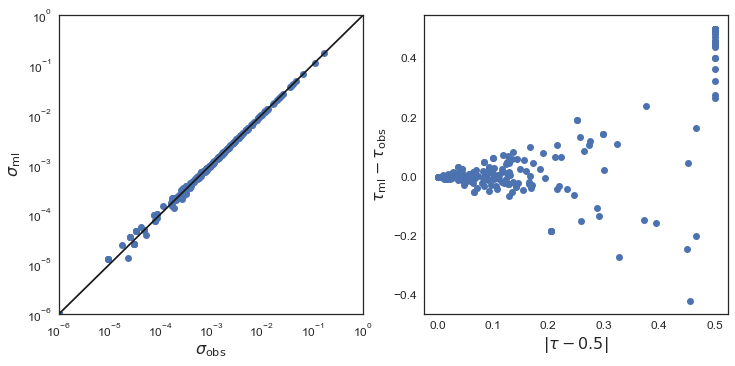

In [28]:
fig=plt.figure(figsize=(12, 5.5))
gs=GridSpec(1,2) # one row, two columns

ax1=fig.add_subplot(gs[0,0]) # first row, first column
ax2=fig.add_subplot(gs[0,1]) # second row, second column

ax1.loglog(sigma+1e-6, sigma_ml+1e-6, 'o')
ax1.loglog([1e-6, 1e0], [1e-6, 1e0], color='k')
ax1.set_xlim([1e-6, 1e0]);
ax1.set_ylim([1e-6, 1e0]);
ax1.set_xlabel(r'$\sigma_{\mathrm{obs}}$')
ax1.set_ylabel(r'$\sigma_{\mathrm{ml}}$')

ax2.plot(np.abs(tau-0.5), tau_ml - tau, 'o')
ax2.set_xlabel(r'$|\tau - 0.5|$')
ax2.set_ylabel(r'$\tau_{\mathrm{ml}} - \tau_{\mathrm{obs}}$');

You can see that, for large $\sigma$, or for $\tau$ close to $1/2$, we keep the measured values.  But when $\sigma$ is very small, or if $\tau$ is close to either 0 or 1, then we modify the numbers a bit to push $\tau$ slightly closer to $1/2$.

We can also investigate how the mean rates $\mu$ change:

In [30]:
mu_m_ml = sigma_ml * tau_ml
mu_h_ml = sigma_ml * (1.0-tau_ml)

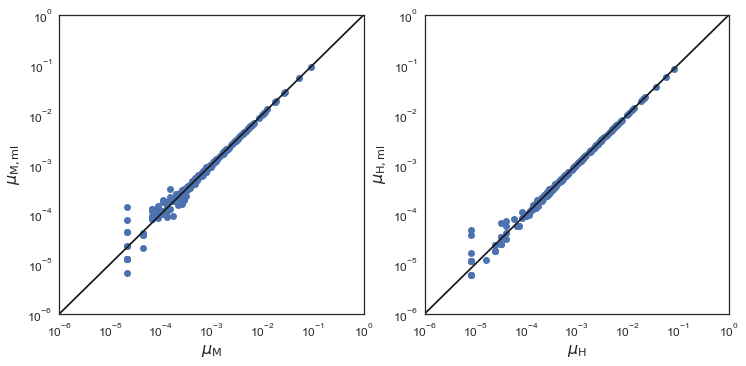

In [31]:
fig=plt.figure(figsize=(12, 5.5))
gs=GridSpec(1,2) # one row, two columns

ax1=fig.add_subplot(gs[0,0]) # first row, first column
ax2=fig.add_subplot(gs[0,1]) # second row, second column

ax1.loglog(mu_m, mu_m_ml, 'o')
ax1.loglog([1e-6, 1e0], [1e-6, 1e0], color='k')
ax1.set_xlim([1e-6, 1e0]);
ax1.set_ylim([1e-6, 1e0]);
ax1.set_xlabel('$\mu_{\mathrm{M}}$')
ax1.set_ylabel('$\mu_{\mathrm{M,ml}}$')

ax2.loglog(mu_h, mu_h_ml, 'o')
ax2.loglog([1e-6, 1e0], [1e-6, 1e0], color='k')
ax2.set_xlim([1e-6, 1e0]);
ax2.set_ylim([1e-6, 1e0]);
ax2.set_xlabel('$\mu_{\mathrm{H}}$')
ax2.set_ylabel('$\mu_{\mathrm{H,ml}}$');

For the most part, low values of $\mu$ get scattered slightly upwards.

Let's use the updated estimates for $\mu$ to improve our inferences about authorship:

In [32]:
def guess_author_new(filename):
    nu, xu = measure(filename)
    lnprob = xu * np.log((mu_m_ml+1e-6)/(mu_h_ml+1e-6)) - nu * (mu_m_ml - mu_h_ml)
    return np.sum(lnprob)

In [33]:
a1 = map(guess_author,     glob.glob('../authors/unknown-federalist/*.txt'))
a2 = map(guess_author_new, glob.glob('../authors/unknown-federalist/*.txt'))

In [34]:
import pandas as pd

In [35]:
df = pd.DataFrame({'naive' : np.round(a1).astype(int),
                   'ML'    : np.round(a2).astype(int),
                   'Delta' : np.round(np.asarray(a2) - np.asarray(a1)).astype(int)})

In [36]:
df[['naive', 'ML', 'Delta']]

,naive,ML,Delta
0,47,61,14
1,31,39,8
2,10,19,9
3,22,17,-5
4,33,28,-5
5,70,55,-15
6,42,40,-2
7,45,40,-5
8,38,33,-5
9,14,14,0


## Why such a big change?!

You can see that this exercise appreciably altered our determinations... in some cases, our certainty went way up (by a factor of $e^{14} \sim 1.2\,\mathrm{million}$!), and in some cases it went way down (by a factor of $e^{-15} \sim 3.5\,\mathrm{million}$!).  Note however, it did not change our *conclusion* about who likely wrote the papers, which remains very certain.  It only changed our certainty about that conlusion.  Nonetheless, it's hardly comforting to see such large changes, so it's worth understanding them.

Let's take a look at the first document, Federalist #18, for which the certainty went way up.  Assuming that Madison indeed wrote this paper, then our model became far better.  To understand why, let's assume that he *never* used the word "largely" in the training set, but that Hamilton used it once.  And let's assume that the word appears once in Federalist #18.  Our first model would count this exceedingly strongly against Madison, but is that reasonable?  He's allowed to pen the word "largely," once, if he wants to, right?

So adjusting the words with extreme values of tau seems to help with this problem.

We can confirm that this is the right explanation by finding the words for which our estimated $\tau$ changed the most:

In [33]:
ind = np.where(np.abs(tau_ml - tau) > 0.4)[0]

In [34]:
badwords = [stopwords[i] for i in ind]
print badwords

['across', 'along', 'anyone', 'anything', 'argue', 'around', 'back', 'became', 'behind', 'cannot', 'comparable', 'dramatically', 'everyone', 'get', 'go', 'imply', 'largely', 'moreover', 'mostly', 'nobody', 'noone', 'seemed', 'seeming', 'someone', 'somewhere', 'suggest', 'toward', 'typical', 'typically', 'using', 'yours']


And we can confirm that these are words which barely appear in the training set, especially Madison's:

In [35]:
print xh[ind]
print xm[ind]

[0 2 0 4 3 0 0 5 1 0 0 0 0 4 9 9 0 0 0 0 0 1 1 0 3 4 4 0 0 3 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


And now we can check that some of these words indeed appear in the Federalist #18:

In [36]:
nu, xu = measure('../authors/unknown-federalist/18.txt')
print xu[ind]

[0 0 0 0 0 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]


So it does appear that our inference for Federalist #18 moved so much because it contains a few words which are rare in Hamilton's training set, but which don't appear at all in Madison's.  In our first model, this strongly (and artifically) penalized Madison.  As a last step, we can make sure these three words in fact account for most of the change in our certainty:

In [37]:
lnpold = (xu * np.log((mu_m+1e-6)/(mu_h+1e-6)) - nu * (mu_m - mu_h))[ind]
lnpnew = (xu * np.log((mu_m_ml+1e-6)/(mu_h_ml+1e-6)) - nu * (mu_m_ml - mu_h_ml))[ind]

diff = np.clip(lnpnew - lnpold, a_min = 1, a_max=None)-1

In [38]:
df = pd.DataFrame({'words' : badwords,
                   'xh' : xh[ind],
                   'xm' : xm[ind],
                   'xu' : xu[ind],
                   'delta' : np.round(diff).astype(int)})

df[['words', 'xh', 'xm', 'xu', 'delta']].style.applymap(lambda(x) : 'color: red' if x > 0 else 'color: black', subset = ['delta'])

,words,xh,xm,xu,delta
0,across,0,0,0,0
1,along,2,0,0,0
2,anyone,0,0,0,0
3,anything,4,0,0,0
4,argue,3,0,0,0
5,around,0,0,1,0
6,back,0,0,0,0
7,became,5,0,3,9
8,behind,1,0,0,0
9,cannot,0,0,0,0


## now the decrease in certainty

Now let's look at Federalist #51, for which our estimated certainty went *down* by $e^{-15}$.

In [39]:
print xh[ind]
print xm[ind]

[0 2 0 4 3 0 0 5 1 0 0 0 0 4 9 9 0 0 0 0 0 1 1 0 3 4 4 0 0 3 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [40]:
nu, xu = measure('../authors/unknown-federalist/51.txt')
print xu[ind]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


Here we see the opposite pattern: Federalist #51 contains the word "moreover," which appears exactly once in Madison's training set, and never in Hamilton's.  In our original model, this word alone penalized Hamilton by a factor of one million, which is suspiciously close to $e^{15}$ after you allow for rounding errors.  Correcting our estimates for the true rates $\mu_{\text{M}}$ and $\mu_{\text{H}}$ significantly helped here.

So the (huge) changes in log-likelihood all come from words which do not appear in Madison's training set, but which do appear in Hamilton's (or vice-versa).  In our first model, this meant we assumed a Poisson distribution with a mean rate $\mu \sim 10^{-6}$, which makes it excessively unlikely to *ever* see the word appear.  But just because Madison never used the word "became" in the training set, does that mean he's never allowed to use it, *ever*?  Of course not!  Moreover, the words which appear only once in the training set are the noisiest: that should be $1{\pm}1$.  So it's ridicuous for us to have given them so much weight!

So even though it's not technically correct to assume that $\sigma$ and $\tau$ are fundamental parameters, or that they follow the $\beta$ distribution as Mosteller & Wallace did, this calculation improved things by effectively jittering the measured rates a little, making it so that zero isn't such a death sentence for the word.

So we've done a Bayesian calculation for the priors inside a Bayesian calculation, and it really improved things... that's pretty cool!

BUT, these numbers still seem very high... can we really say with that Madison wrote these papers with probability $(1-e^{-40})$?  The Achilles heel of the calculation is still our assumption of the Poisson distribution, which we haven't addressed yet.

We'll tackle that in the next notebook, which will also remove the need for funky assumptions about $\sigma$ and $\tau$.